In [1]:
# Import des librairies nécessaires
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor

from lazypredict.Supervised import LazyRegressor

# Pour l'approche bayésienne
from skopt import gp_minimize
from skopt.space import Real, Integer

import shap

In [2]:
def score(y_test, y_pred ) :
    "fonction pour calculer les performances du modele"
    
    MSE = mean_squared_error(y_test, y_pred).round(3)
    RMSE = np.sqrt(MSE).round(3)
    MAE = mean_absolute_error(y_test, y_pred).round(3)
    r2 = r2_score(y_test, y_pred).round(3).round(3)
    
    print(f'MSE : {MSE} || RMSE : {RMSE} || MAE : {MAE} || r² : {r2}')

In [3]:
def display_feat_imp_reg(reg):
    '''afficher l'importance des variables dans nos modèles'''

    feat_imp_reg = reg.coef_
    reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
    reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
    reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
    reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

In [4]:
def display_feat_imp_rforest(rforest, X_train):
    '''afficher l'importance des variables dans nos modèles de random forest'''
    feat_imp = rforest.feature_importances_
    df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
    df_featimp["Feature Name"] = X_train.columns
    df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
    print(df_featimp)
    df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

In [5]:
def resultize(grid) : 
    '''Creation d'un dataframe contenant les hyperparametres des meilleurs résultats du grid search'''
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    
    return res

In [6]:
path = 'cleaned/'
filename = 'dataset_cleaned.csv'

In [7]:
df = pd.read_csv(path+filename)

In [8]:
path2 = 'cleaned/'
filename2 = 'dataset_cleaned2.csv'

In [9]:
# Utilisation du dataset original comprenant quelques modifications de nettoyage, pour pouvoir rajouter de nouvelles variables
data2 = pd.read_csv(path2+filename2)

In [10]:
df.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFATotal,TotalGHGEmissions,SiteEnergyUse(kBtu)
0,1927.00,1.00,2.72,88434.00,88434.00,249.98,7226362.50
1,1996.00,1.00,2.72,88502.00,103566.00,295.86,8387933.00
2,1969.00,1.00,2.72,55045.34,58763.76,41.96,3618397.81
3,1926.00,1.00,2.72,61320.00,61320.00,286.43,6794584.00
4,1980.00,1.00,2.72,113580.00,175580.00,41.96,14172606.00


### Consommation d'energie

#### Data preparation

In [11]:
# On supprime la 2eme target, qui est les emissions en CO2
df_energy = df.drop('TotalGHGEmissions', axis = 1)

In [12]:
# On retire la target pour le X qui sera contenu dans Y
X2 = df_energy.drop("SiteEnergyUse(kBtu)", axis = 1)
y2 = df_energy["SiteEnergyUse(kBtu)"]

#### Validation croisée

In [13]:
# Création des modèles à tester
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))
models.append(('DRMean', DummyRegressor(strategy = 'mean')))
models.append(('DRMed',DummyRegressor(strategy = 'median')))

In [14]:
# Évaluation des modèles en utilisant la validation croisée
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X2, y2, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)

LR: 8448178347465.656250 (1984991834265.125488)
RF: 8869682367085.746094 (1673125402201.313721)
DRMean: 11053126054081.332031 (1975385505488.013428)
DRMed: 11928978583275.466797 (2430266779679.644531)


In [15]:
# Separer le jeu de données en données d'entrainement et de test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 42)

In [16]:
print(f'Nous avons X_train de forme {X_train2.shape} et y_train de forme {y_train2.shape}')
print(f'Nous avons X_test de forme {X_test2.shape} et y_test de forme {y_test2.shape}')

Nous avons X_train de forme (1059, 5) et y_train de forme (1059,)
Nous avons X_test de forme (454, 5) et y_test de forme (454,)


###### Validation croisée

In [17]:
# Instancier la regression lineaire
lr = LinearRegression()

In [18]:
# Cross validation pour observer si notre modele va overfitter
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores2 = cross_val_score(lr, X2, y2, cv=cv)
# Calcul du score
score2 = scores2.mean()
print('Score: %.3f (%.3f)' % (score2, scores2.std()))

Score: 0.224 (0.086)


On observe un score de 0.224% environ.

### Modelisation 

#### Dummy regressor

In [19]:
# Appliquer un dummy regressor avec la strategie de la moyenne 
lm_dummy_mean2 = DummyRegressor(strategy = 'mean')
lm_dummy_mean2.fit(X_train2, y_train2)

# Appliquer un dummy regressor avec la strategie de la mediane 
lm_dummy_median2 = DummyRegressor(strategy = 'median')
lm_dummy_median2.fit(X_train2, y_train2)

DummyRegressor(strategy='median')

In [20]:
# Calculer les données prédites à partir de nos modeles
y_pred_mean2 = lm_dummy_mean2.predict(X_test2)


y_pred_median2 = lm_dummy_median2.predict(X_test2)

In [57]:
# Observation de la forme de la target
y_test2.values

array([ 3835202.        ,  3618397.81369269,   966907.375     ,
        2472350.25      ,  8663691.        ,   412562.4063    ,
        3618397.81369269,  6062770.5       ,  3460275.5       ,
        1761137.5       ,  6787070.        , 10077532.        ,
        7683885.        ,  2042771.        ,  2100216.5       ,
         716279.6875    ,   150167.7969    ,  1262235.25      ,
        3618397.81369269,  1642471.5       ,  3618397.81369269,
        1992158.25      ,   227509.5       ,  2582687.        ,
       15067340.        ,  1264626.875     ,  6468090.        ,
        5413418.        ,   544172.375     ,   940844.6875    ,
        3618397.81369269,  9080022.        ,   216115.        ,
        1380293.625     ,  1288669.5       ,  1577040.875     ,
        4420650.5       ,   439065.9063    ,   576174.125     ,
        4747403.5       ,  1386445.375     ,  4801472.        ,
         739210.5       ,  4166306.25      ,  1094940.75      ,
        6876439.5       ,  3618397.81369

In [21]:
score(y_test2,y_pred_mean2)

MSE : 12600529628358.217 || RMSE : 3549722.472 || MAE : 2626273.028 || r² : -0.004


In [22]:
score(y_test2,y_pred_median2)

MSE : 13799684071977.16 || RMSE : 3714792.601 || MAE : 2568843.54 || r² : -0.1


On a donc nos scores de base à partir desquels nous comparerons les scores de nos modèles pour voir si il est judicieux de les utiliser ou non. 

#### Regression lineaire 

In [23]:
# Appliquer la regression lineaire à nos données d'entrainement 
lr3 = lr

lr3.fit(X_train2, y_train2)

LinearRegression()

In [24]:
# Observer les données prédites à partir de nos modeles
y_pred3 = lr3.predict(X_test2)

In [25]:
score(y_test2, y_pred3)

MSE : 9793757276633.795 || RMSE : 3129497.927 || MAE : 2219833.589 || r² : 0.219


On observe des scores bien meilleur que le dummy regressor, ce qui nous prouve que notre modèle apprend mieux que le modele de base dans ce cas là.  
Il faudrait s'intéresser à la valeur des erreurs, pourquoi est-elle si elevée (stanadardisation ?)

#### Standardisation

In [26]:
scaler = StandardScaler()

# Normaliser notre jeu d'entrainement
normalized_X_train2 = pd.DataFrame(
    scaler.fit_transform(X_train2),
    columns = X_train2.columns
)

In [27]:
# Appliquer la regression lineaire à nos données normalisées
lr3_std = lr

lr3_std.fit(normalized_X_train2, y_train2)

LinearRegression()

In [28]:
# Normaliser le jeu de test avec les informations retenues de la premiere normalisation 
normalized_X_test2 = pd.DataFrame(
    scaler.transform(X_test2),
    columns = X_test2.columns
)

In [29]:
# Observer les données prédites
y_pred3_std = lr3_std.predict(normalized_X_test2)

In [30]:
score(y_test2, y_pred3_std)

MSE : 9793757276633.781 || RMSE : 3129497.927 || MAE : 2219833.589 || r² : 0.219


Les résultats sont sensiblement les mêmes.

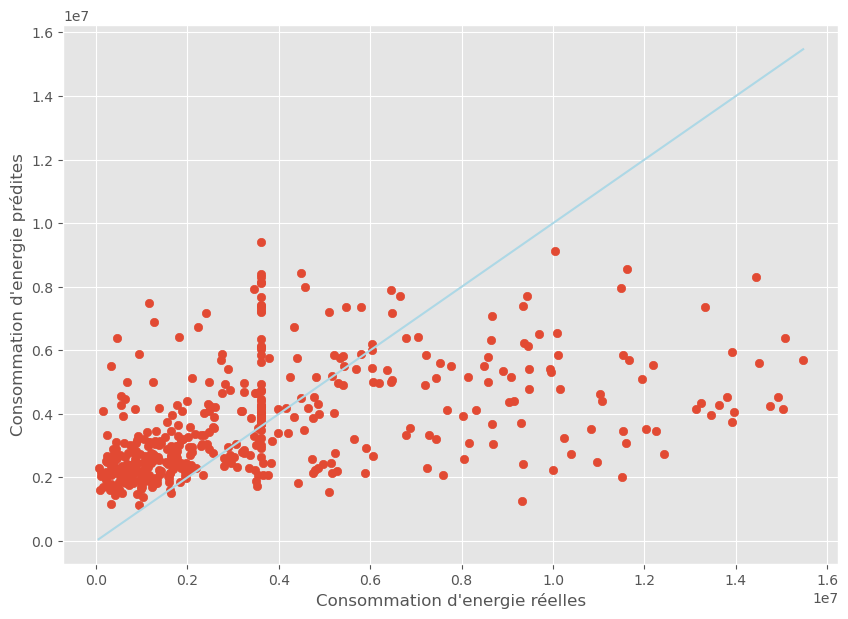

In [31]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test2,y_pred3)
plt.plot([np.min(y_test2), np.max(y_test2)], [np.min(y_test2), np.max(y_test2)], color='lightblue')
plt.xlabel("Consommation d'energie réelles")
plt.ylabel("Consommation d'energie prédites")
plt.show()

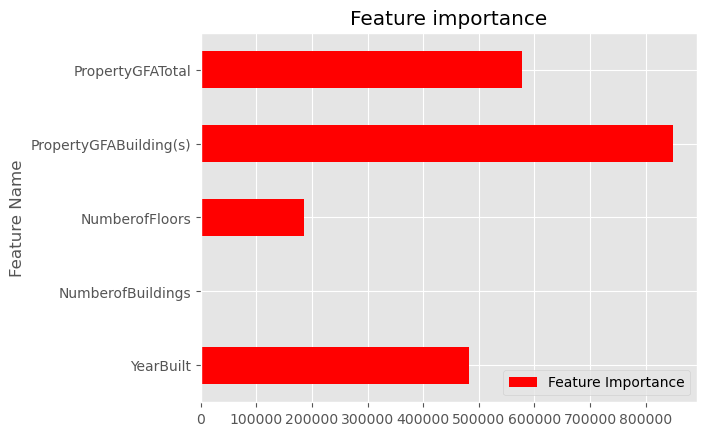

In [32]:
display_feat_imp_reg(lr3)

#### Random Forest

In [33]:
# Instancier le random forest
rf = RandomForestRegressor()

In [34]:
# Cross validation pour le random forest
scores4 = cross_val_score(rf, X2, y2, cv=cv)
# Calcul des scores
score4 = scores4.mean()
print('Score: %.3f (%.3f)' % (score4, scores4.std()))

Score: 0.210 (0.092)


On observe un score de 0.21, ce qui est une très bonne nouvelle.  
Cela montre que le random forest semble apprendre mieux que la regression lineaire dans ce cas là.

In [35]:
# On instancie le modele et on l'entraine avec les hyper-paramètres de base
rf3 = rf
rf3.fit(X_train2, y_train2)

RandomForestRegressor()

In [36]:
# On regarde les prédictions 
y_pred4 = rf3.predict(X_test2)

In [37]:
score(y_test2, y_pred4)

MSE : 9408764520329.123 || RMSE : 3067370.946 || MAE : 2181977.63 || r² : 0.25


On observe de meilleurs résultats que avec la regression lineaire, ce qui vient confirmer notre hypothèse de la cross validation.

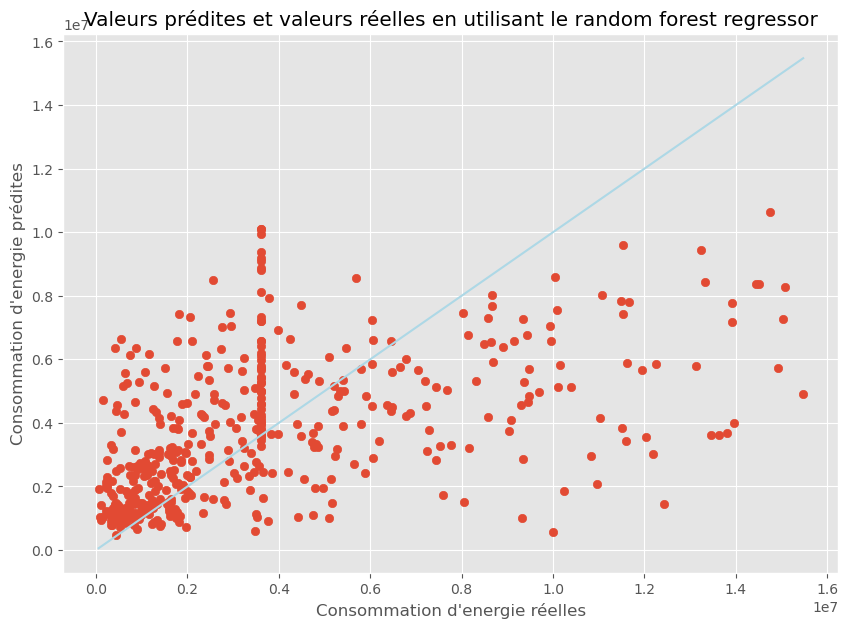

In [38]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test2,y_pred4)
plt.plot([np.min(y_test2), np.max(y_test2)], [np.min(y_test2), np.max(y_test2)], color='lightblue')
plt.xlabel("Consommation d'energie réelles")
plt.ylabel("Consommation d'energie prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

   Feature Importance            Feature Name
4                0.39        PropertyGFATotal
3                0.26  PropertyGFABuilding(s)
0                0.24               YearBuilt
2                0.10          NumberofFloors
1                0.00       NumberofBuildings


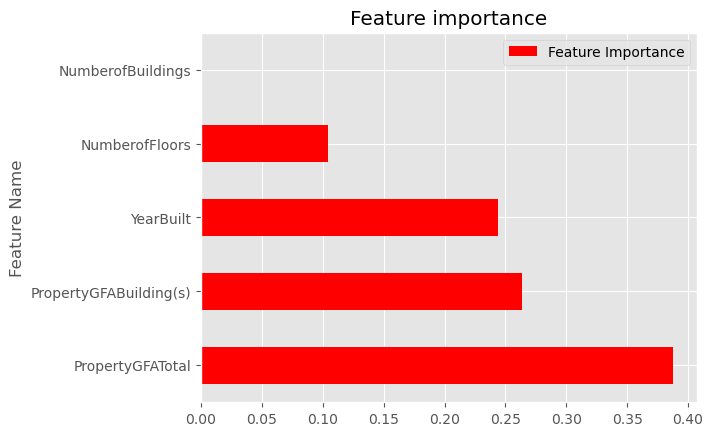

In [39]:
display_feat_imp_rforest(rf3, X_train2)

On voit que dans ce cas là, les variables les plus importantes pour le modele sont l'electricité, la quantité annuelle de gaz consommé et l'intensité des emissions de GES.

### Trouver les hyper-paramètres

#### Regression lineaire

In [40]:
lr4 = lr

In [41]:
# Créer une grille de paramètre pour la regression lineaire
param_grid = {'normalize': [True, False],
              'fit_intercept': [True, False],
              'copy_X': [True, False]}

In [42]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(lr4, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True)

In [43]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [44]:
resultize(grid).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,0.00,0.00,0.00,0.00,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.24,0.06,1,0.25,0.02
5,0.00,0.00,0.00,0.00,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.24,0.06,1,-93.07,12.90
0,0.00,0.00,0.00,0.00,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.24,0.06,3,0.25,0.02
4,0.00,0.00,0.00,0.00,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.24,0.06,3,-93.32,12.90
2,0.00,0.00,0.00,0.00,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.24,0.06,5,0.25,0.02


In [45]:
# On instancie la regression lineaire avec les meilleurs parametres puis on entraine nos données avec ce modele
lr4 = LinearRegression(**best_params)
lr4.fit(X_train2, y_train2)
y_pred3_bis = lr4.predict(X_test2)

In [46]:
score(y_test2, y_pred3_bis)

MSE : 9793757276633.795 || RMSE : 3129497.927 || MAE : 2219833.589 || r² : 0.219


On observe des erreurs legerement plus faible qu'avec la regression lineaire de base. 

#### Random forest

In [47]:
rf4 = rf

In [48]:
# On definit les paramètres 
param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15]}

In [49]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(rf4, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True)

In [50]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}

In [128]:
resultize(grid).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
13,3.80,0.17,0.07,0.01,15,auto,500,"{'max_depth': 15, 'max_features': 'auto', 'n_e...",0.75,0.02,1,0.97,0.00
12,1.55,0.02,0.03,0.00,15,auto,200,"{'max_depth': 15, 'max_features': 'auto', 'n_e...",0.75,0.02,2,0.97,0.00
7,3.13,0.07,0.06,0.00,10,auto,500,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.75,0.02,3,0.95,0.00
6,1.29,0.08,0.02,0.00,10,auto,200,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.75,0.02,4,0.95,0.00
17,1.72,0.05,0.07,0.00,15,log2,500,"{'max_depth': 15, 'max_features': 'log2', 'n_e...",0.74,0.02,5,0.96,0.00


In [51]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf4 = RandomForestRegressor(**best_params)
rf4.fit(X_train2, y_train2)
y_pred4_bis = rf4.predict(X_test2)

In [52]:
score(y_test2, y_pred4_bis)

MSE : 8854902916501.295 || RMSE : 2975718.891 || MAE : 2133285.755 || r² : 0.294


   Feature Importance            Feature Name
3                0.40  PropertyGFABuilding(s)
4                0.39        PropertyGFATotal
0                0.15               YearBuilt
2                0.07          NumberofFloors
1                0.00       NumberofBuildings


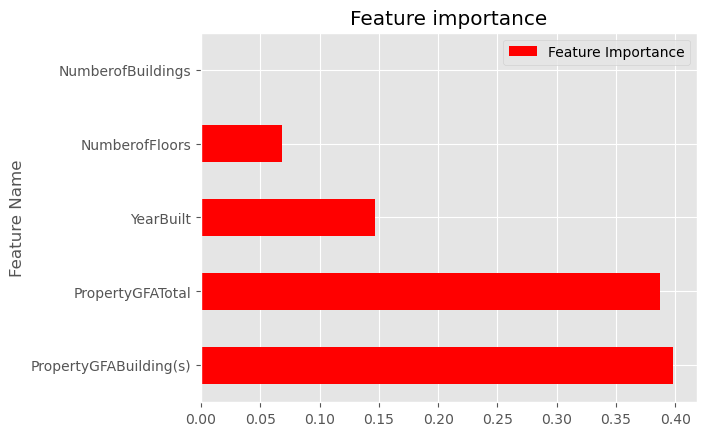

In [53]:
display_feat_imp_rforest(rf4, X_train2)

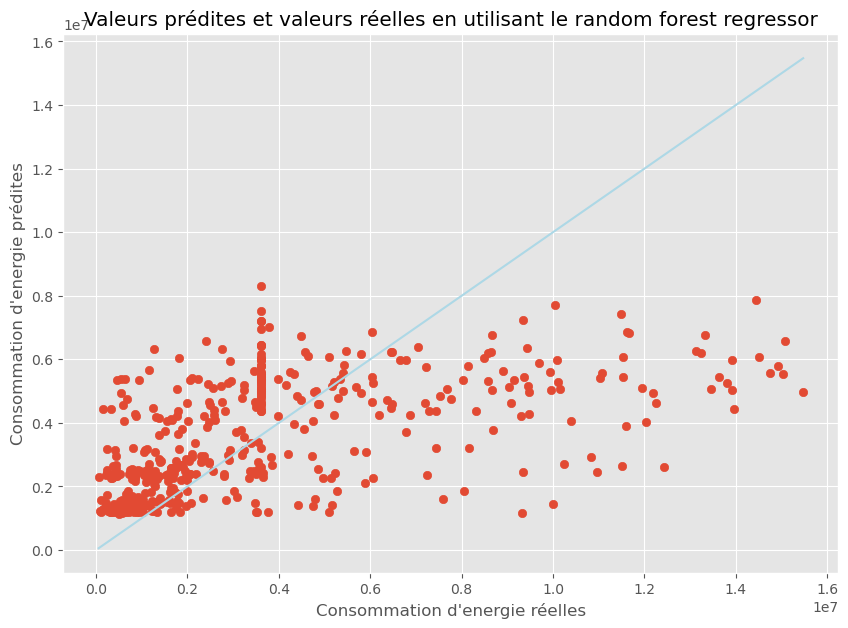

In [54]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test2,y_pred4_bis)
plt.plot([np.min(y_test2), np.max(y_test2)], [np.min(y_test2), np.max(y_test2)], color='lightblue')
plt.xlabel("Consommation d'energie réelles")
plt.ylabel("Consommation d'energie prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

###### random search

In [55]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [56]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [57]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train2, y_train2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [58]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20}

In [59]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf4_random = RandomForestRegressor(**best_params)
rf4_random.fit(X_train2, y_train2)
y_pred4_random = rf4_random.predict(X_test2)

In [60]:
score(y_test2, y_pred4_random)

MSE : 8676270916427.274 || RMSE : 2945551.038 || MAE : 2115473.889 || r² : 0.308


On observe des scores meilleurs que pour l'entrainement avec les parametres par defaut et meilleurs que pour l'entrainement avec grid search. On va tester la méthode bayésienne. 

#### Approche bayésienne

In [61]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective3(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rmse = -cross_val_score(randomF, X2, y2, scoring='neg_root_mean_squared_error', cv=5).mean()
    return rmse

In [62]:
# Définir l'espace de recherche pour les hyperparamètres
space = [Integer(10, 500, name='n_estimators'),
         Integer(1, 20, name='max_depth'),
         Integer(2, 20, name='min_samples_split'),
         Integer(1, 20, name='min_samples_leaf')]

In [63]:
# Nombre d'itération
n_it = 50

In [64]:
# Lancer l'optimisation bayésienne 
result = gp_minimize(objective3, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [65]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result.x[0]
best_max_depth = result.x[1]
best_min_samples_split = result.x[2]
best_min_samples_leaf = result.x[3]
best_rmse = -result.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 273
Best max_depth: 3
Best min_samples_split: 11
Best min_samples_leaf: 9
Best RMSE: -2817125.252042205


In [66]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf4_by = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)
rf4_by.fit(X_train2, y_train2)


y_pred4_by = rf4_by.predict(X_test2)
test_rmse = mean_squared_error(y_test2, y_pred4_by, squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 2995994.393389538


In [67]:
score(y_test2, y_pred4_by)

MSE : 8975982405221.545 || RMSE : 2995994.393 || MAE : 2145333.077 || r² : 0.285


On remarque que dans le cas de l'étude de la consommation d'energie, le random forest optimisé à l'aide du random search est la méthode qui nous renvoie les meilleurs performances.

### Ajout de variables catégorielles 

In [68]:
data_enc = data2.copy()

### Consommation d'energie

#### Data preparation

In [69]:
# On supprime la 2eme target, qui est les emissions de GHG
df_energy2 = data_enc.drop('TotalGHGEmissions', axis = 1) 

In [70]:
# On retire la target pour le X qui sera contenu dans Y
X4 = df_energy2.drop("SiteEnergyUse(kBtu)", axis = 1)
y4 = df_energy2["SiteEnergyUse(kBtu)"]

#### Validation croisée

In [71]:
# Cross validation
scores6 = cross_val_score(lr, X4, y4, cv=cv)
# Calcul des scores
score6 = scores6.mean()
print('Score: %.3f (%.3f)' % (score6, scores6.std()))

Score: 0.236 (0.088)


On observe une amélioration par rapport à l'entrainement du modele sans données catégorielles.

In [72]:
# Separer le jeu de données en données d'entrainement et de test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = 0.3)

In [73]:
print(f'Nous avons X_train de forme {X_train4.shape} et y_train de forme {y_train4.shape}')
print(f'Nous avons X_test de forme {X_test4.shape} et y_test de forme {y_test4.shape}')

Nous avons X_train de forme (1059, 7) et y_train de forme (1059,)
Nous avons X_test de forme (455, 7) et y_test de forme (455,)


#### Regression lineaire

In [74]:
# Appliquer la regression lineaire à nos données d'entrainement 
lr7 = lr

lr7.fit(X_train4, y_train4)

LinearRegression()

In [75]:
# Observer les données prédites à partir de nos modeles
y_pred7 = lr7.predict(X_test4)

In [76]:
score(y_test4, y_pred7)

MSE : 7324277241116.928 || RMSE : 2706340.193 || MAE : 1852452.134 || r² : 0.266


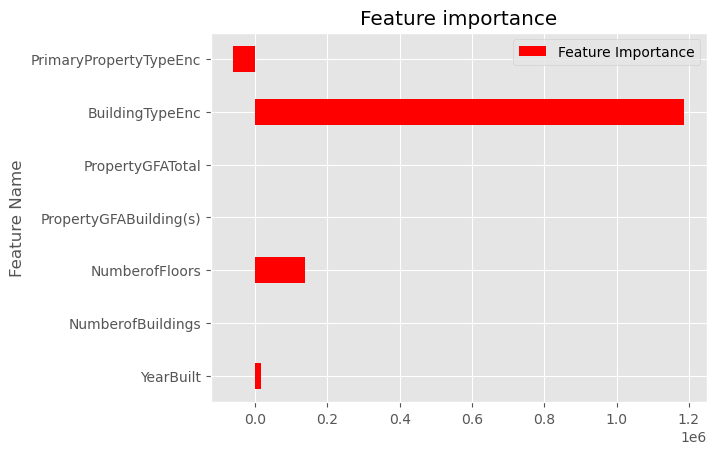

In [77]:
display_feat_imp_reg(lr7)

On remarque que les scores sont meilleurs que sans les données catégorielles, et le type de batiment a une grande importance dans le modele.

#### Random Forest

In [78]:
# Cross validation pour le random forest
scores8 = cross_val_score(rf, X4, y4, cv=cv)
# Calcul des scores
score8 = scores8.mean()
print('Score: %.3f (%.3f)' % (score8, scores8.std()))

Score: 0.357 (0.099)


On observe de meilleurs résultats que l'entrainement sans les données catégorielles.

In [79]:
# On instancie le modele et on l'entraine avec les hyper-paramètres de base
rf7 = rf
rf7.fit(X_train4, y_train4)

RandomForestRegressor()

In [80]:
# On regarde les prédictions 
y_pred8 = rf7.predict(X_test4)

In [81]:
score(y_test4, y_pred8)

MSE : 6452317433003.95 || RMSE : 2540141.223 || MAE : 1706892.406 || r² : 0.353


   Feature Importance            Feature Name
3                0.26  PropertyGFABuilding(s)
4                0.24        PropertyGFATotal
6                0.21  PrimaryPropertyTypeEnc
0                0.19               YearBuilt
2                0.08          NumberofFloors
5                0.02         BuildingTypeEnc
1                0.00       NumberofBuildings


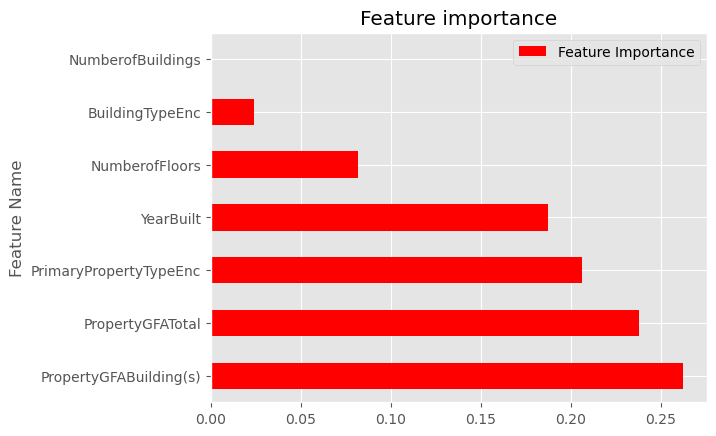

In [82]:
display_feat_imp_rforest(rf7, X_train4)

On remarque que les scores sont largement meilleurs que sans les données catégorielles, mais que les nouvelles variables n'ont pas une grande importance dans le modele.

### Trouver les hyper-paramètres

#### Regression lineaire

In [83]:
lr8 = lr

In [84]:
# Créer une grille de paramètre pour la regression lineaire
param_grid = {'normalize': [True, False],
              'fit_intercept': [True, False],
              'copy_X': [True, False]}

In [85]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(lr8, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train4, y_train4)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True)

In [86]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [87]:
# On instancie la regression lineaire avec les meilleurs parametres puis on entraine nos données avec ce modele
lr8 = LinearRegression(**best_params)
lr8.fit(X_train4, y_train4)
y_pred7_bis = lr8.predict(X_test4)

In [88]:
score(y_test4, y_pred7_bis)

MSE : 7324277241116.96 || RMSE : 2706340.193 || MAE : 1852452.134 || r² : 0.266


Cela ne change rien

#### Random forest

##### Grid Search

In [89]:
rf5 = rf

# On definit les paramètres 
param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15]}

In [90]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(rf5, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train4, y_train4)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True)

In [91]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

In [92]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf5 = RandomForestRegressor(**best_params)
rf5.fit(X_train4, y_train4)

y_pred7_bis = rf5.predict(X_test4)

In [93]:
score(y_test4, y_pred7_bis)

MSE : 6061383192589.444 || RMSE : 2461987.651 || MAE : 1691279.132 || r² : 0.393


Meilleurs résultats.

   Feature Importance            Feature Name
4                0.29        PropertyGFATotal
3                0.27  PropertyGFABuilding(s)
6                0.24  PrimaryPropertyTypeEnc
0                0.13               YearBuilt
2                0.05          NumberofFloors
5                0.02         BuildingTypeEnc
1                0.00       NumberofBuildings


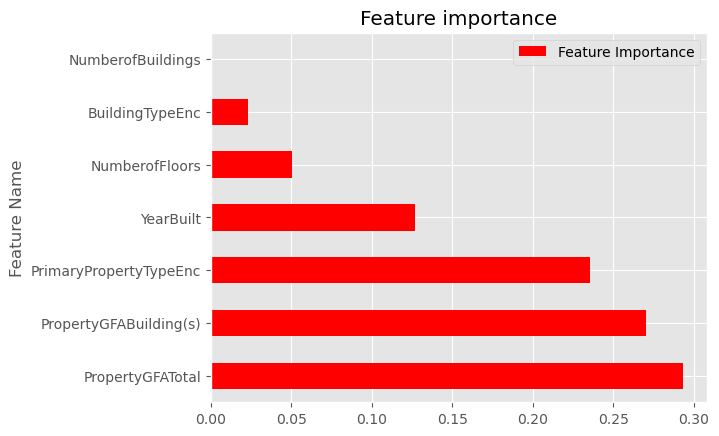

In [172]:
display_feat_imp_rforest(rf8_by, X_train4)

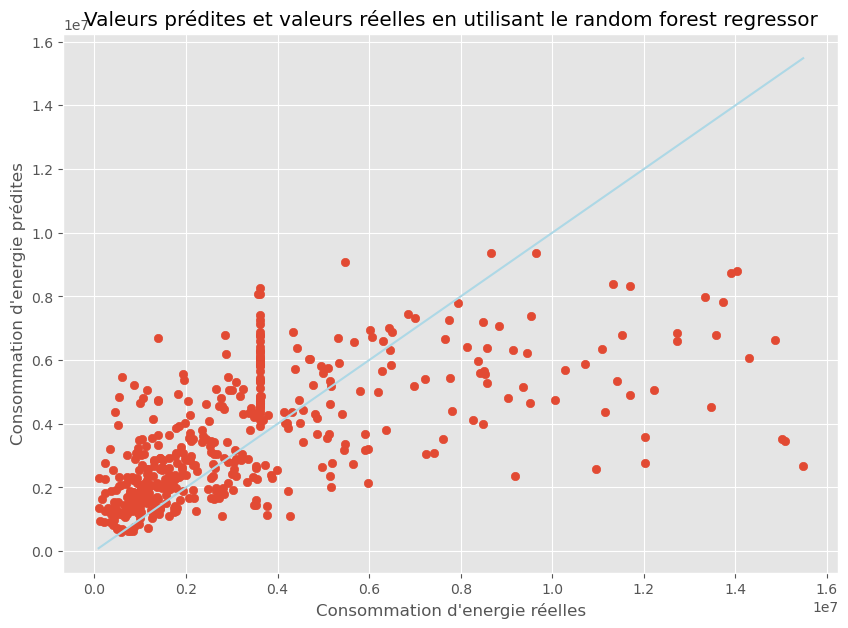

In [95]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test4,y_pred7_bis)
plt.plot([np.min(y_test4), np.max(y_test4)], [np.min(y_test4), np.max(y_test4)], color='lightblue')
plt.xlabel("Consommation d'energie réelles")
plt.ylabel("Consommation d'energie prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

#### Random Search

In [96]:
rf8 = rf

In [97]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [98]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [99]:
# On instancie notre random search et on l'entraine sur nos données
rf_random3 = RandomizedSearchCV(estimator = rf8, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random3.fit(X_train4, y_train4)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [100]:
# Affichage des hyperparametres optimaux
best_params = rf_random3.best_params_
best_params

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [101]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf8_random = RandomForestRegressor(**best_params)
rf8_random.fit(X_train4, y_train4)
y_pred8_random = rf8_random.predict(X_test4)

In [102]:
score(y_test4, y_pred8_random)

MSE : 6023970915686.828 || RMSE : 2454377.908 || MAE : 1686017.527 || r² : 0.396


On observe de meilleurs résultats que avec le grid search

#### Approche bayésienne

In [103]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective4(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rmse = -cross_val_score(randomF, X4, y4, scoring='neg_root_mean_squared_error', cv=5).mean()
    return rmse

In [104]:
# Lancer l'optimisation bayésienne 

result2 = gp_minimize(objective4, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [105]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result2.x[0]
best_max_depth = result2.x[1]
best_min_samples_split = result2.x[2]
best_min_samples_leaf = result2.x[3]
best_rmse = -result2.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 405
Best max_depth: 8
Best min_samples_split: 2
Best min_samples_leaf: 3
Best RMSE: -2579607.1153814504


In [106]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf8_by = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)
rf8_by.fit(X_train4, y_train4)

y_pred8_by = rf8_by.predict(X_test4)

test_rmse = mean_squared_error(y_test4, y_pred8_by, squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 2433557.7082429584


In [107]:
score(y_test4, y_pred8_by)

MSE : 5922203119348.72 || RMSE : 2433557.708 || MAE : 1677564.583 || r² : 0.406


On observe de meilleurs résultats avec l'approche bayésienne.

### Pour la consommation d'energie, on remarque que les données catégorielles améliorent les résultats du random forest. 

## SHAP

In [108]:
rf_regressor1 = shap.TreeExplainer(rf8_by, X_train4)

In [109]:
shap_vals = rf_regressor1.shap_values(X_test4.iloc[0])
print("Expected/Base Value : ", rf_regressor1.expected_value)
print()
print("Shap Values for Sample 0 : ", shap_vals)
print("\n")
print("Prediction From Model                            : ", rf8_by.predict(np.array(X_test4.iloc[0]).reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value : ", rf_regressor1.expected_value + shap_vals.sum())

Expected/Base Value :  3935978.3235227764

Shap Values for Sample 0 :  [-200193.06458336       0.          -20479.73647808 -330318.37216911
  154134.81789978  -25483.55340378 -376154.49885075]


Prediction From Model                            :  3137483.941348852
Prediction From Adding SHAP Values to Base Value :  3137483.9159374796


In [110]:
# Calculer les valeurs shap de notre modele de random forest 
shap_values = rf_regressor1.shap_values(X_test4, check_additivity=False)

# contribution moyenne de chaque variable à chaque prédiction pour chaque instance sur la base de toutes les configurations de variables possibles

 94%|=================== | 428/455 [00:14<00:00]       

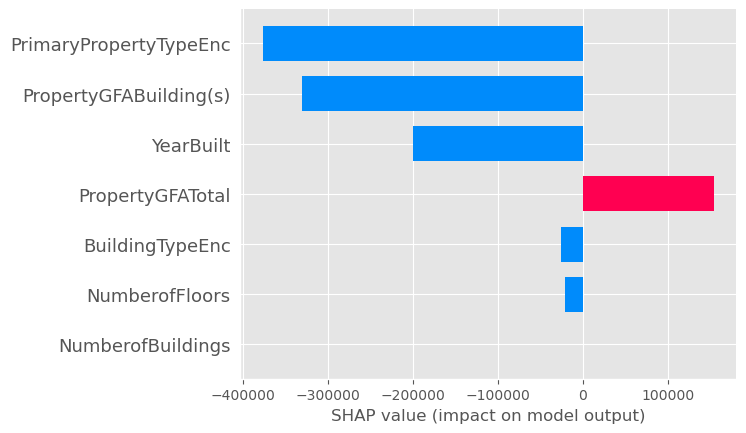

In [111]:
shap.bar_plot(shap_values[0],
              feature_names=X4.columns,
              max_display=len(X4.columns))

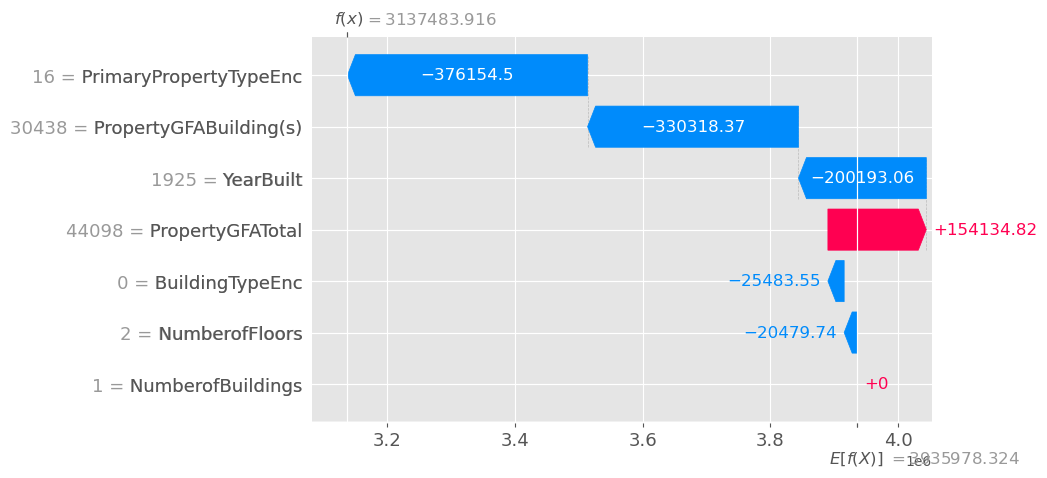

In [112]:
# Waterfall plot pour le premier objet explicatif qui ne tient pas compte de l'interaction entre les objets 

shap_values2 = rf_regressor1(X_test4[:1])
shap.waterfall_plot(shap_values2[0], max_display=len(df_energy2.columns))

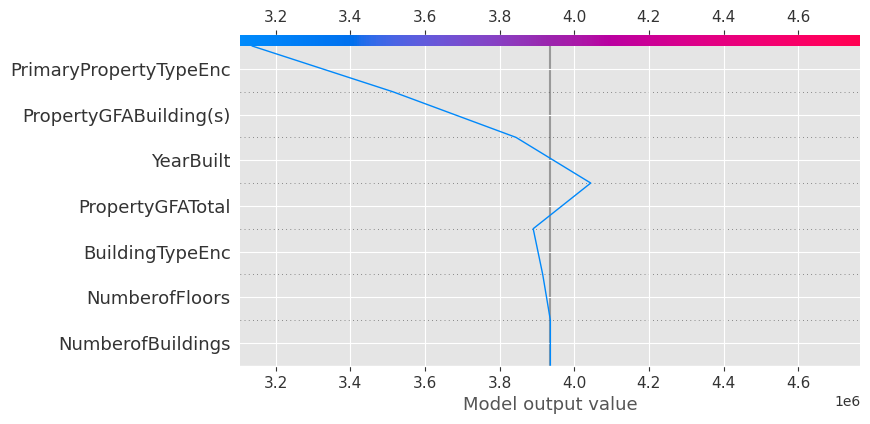

In [113]:
# Diagramme de décision d'un échantillon unique à partir de l'ensemble de données de test en utilisant le premier explicateur de notre random forest
shap.decision_plot(rf_regressor1.expected_value,
                   rf_regressor1.shap_values(X_test4.iloc[0]),
                   feature_names=X4.columns.tolist(),
                   )

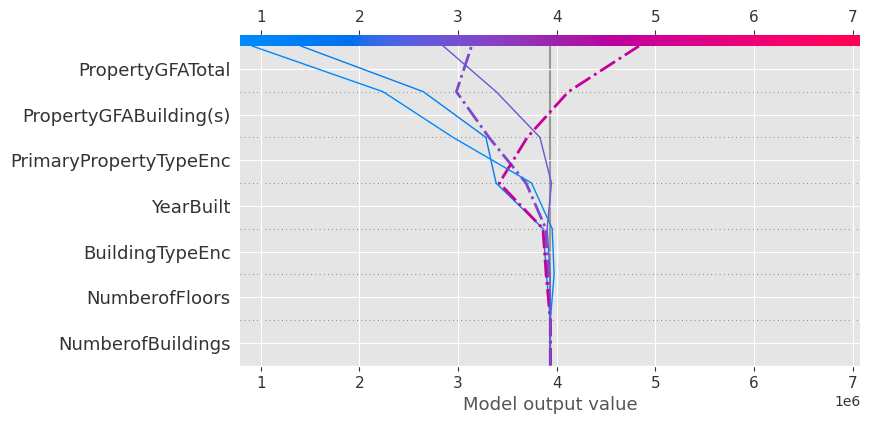

In [114]:
# diagramme de décision de 5 échantillons à partir de l'ensemble de données de test en utilisant le premier explicateur du random forest 
shap.decision_plot(rf_regressor1.expected_value,
                   rf_regressor1.shap_values(X_test4.iloc[0:5]),
                   feature_names=X4.columns.tolist(),
                   highlight=[0, 2],
                   )

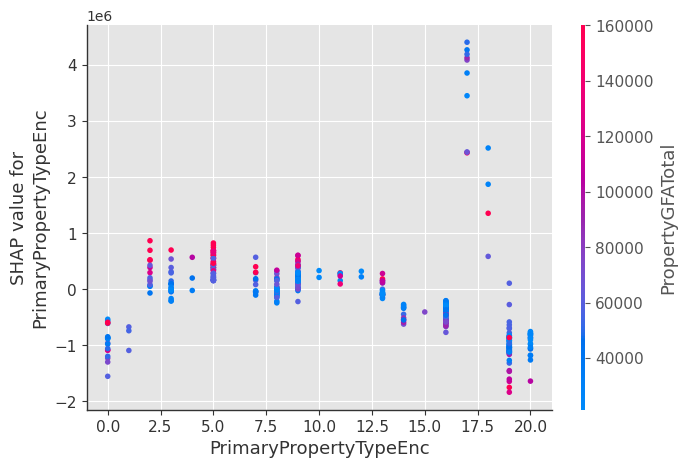

In [116]:
# Montrer la relation entre les valeurs réelles et les valeurs shap pour une variable particulière
shap.dependence_plot("PrimaryPropertyTypeEnc",
                     shap_values,
                     features=X_test4,
                     feature_names=X_test4.columns,
                     )

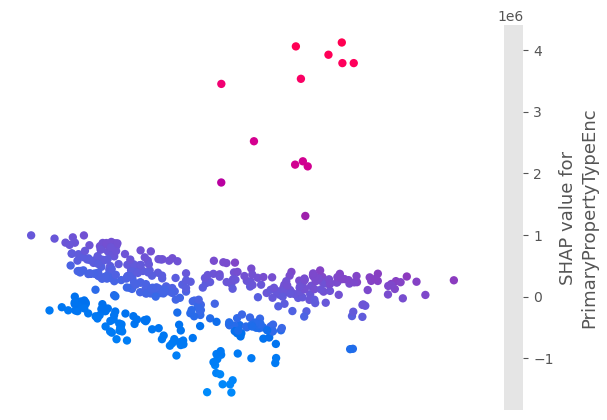

In [118]:
# Répartition des différentes valeurs de forme pour une caractéristique particulière
shap.embedding_plot("PrimaryPropertyTypeEnc",
                    shap_values,
                    feature_names=X_test4.columns)

In [119]:
# Montrer quelles variables ont contribué pour les prédictions finales et de quelle façon
shap.initjs()
shap.force_plot(rf_regressor1.expected_value,
                rf_regressor1.shap_values(X_test4.iloc[0]),
                feature_names=X4.columns.tolist(),
                out_names="consommation "
               )

In [120]:
# force plot de 10 échantillons de l'ensemble de données en utilisant notre explicateur.
shap.force_plot(rf_regressor1.expected_value,
                rf_regressor1.shap_values(X_test4.iloc[0:10]),
                feature_names=X4.columns.tolist(),
                out_names="consommation", figsize=(25,3),
                link="identity")

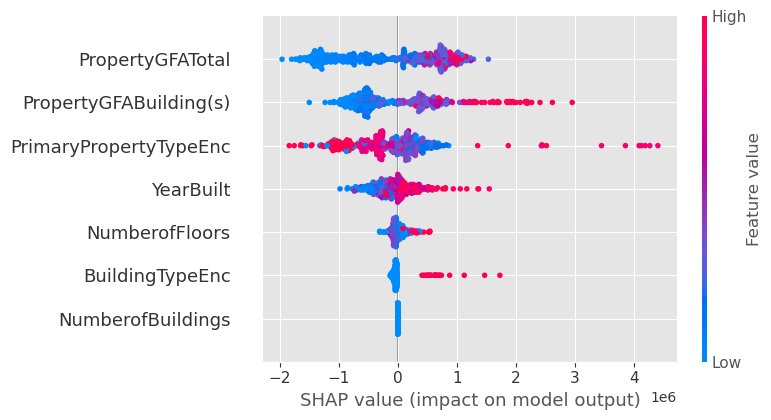

In [121]:
# distribution des valeurs de forme pour toutes les caractéristiques des données
shap.summary_plot(shap_values,
                  features = X_test4,
                  feature_names=X4.columns.tolist())

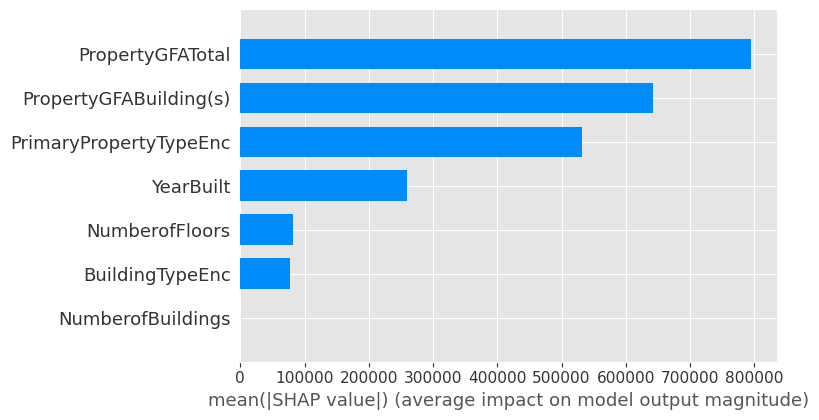

In [122]:
# impact moyen de chaque variable sur la prédiction finale et feature importance
shap_values_summary = shap.summary_plot(shap_values,feature_names=X4.columns.tolist(), plot_type='bar')

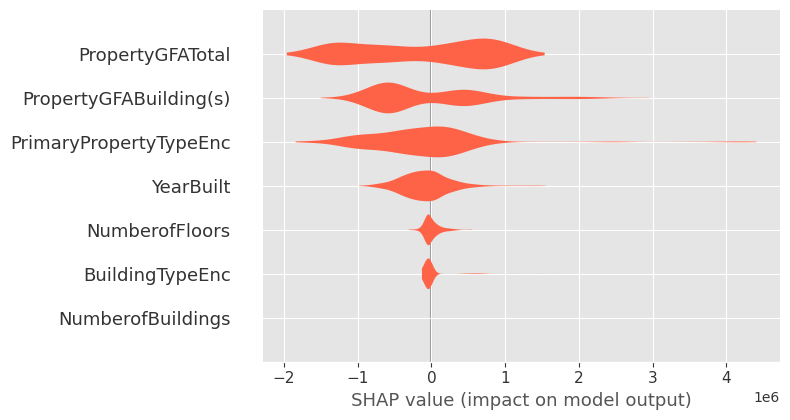

In [123]:
# Type de graphique en violon
shap.summary_plot(shap_values,
                  feature_names=X4.columns.tolist(),
                  plot_type="violin",
                  color="tomato")

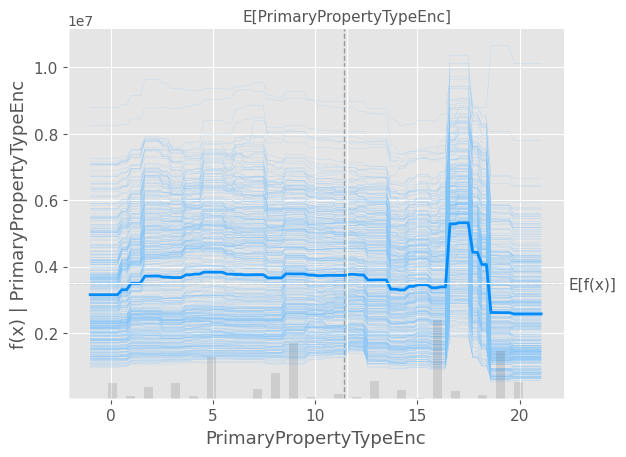

In [124]:
# graphique de dépendance partielle
shap.partial_dependence_plot("PrimaryPropertyTypeEnc",
                             rf5.predict,
                             data=X_test4,
                             feature_names=X4.columns.tolist(),
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True
                             )

#### On ajoute a présent la variable ENERGYSTARScore à notre modele

In [125]:
path = 'cleaned/'
filename = 'dataset_cleaned2_EnergyScore.csv'

In [126]:
data = pd.read_csv(path+filename)

In [127]:
data.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFATotal,TotalGHGEmissions,SiteEnergyUse(kBtu),BuildingTypeEnc,PrimaryPropertyTypeEnc,ENERGYSTARScore
0,1927.00,1.00,2.72,88434.00,88434.00,249.98,7226362.50,0,2,60.00
1,1996.00,1.00,2.72,88502.00,103566.00,295.86,8387933.00,0,2,61.00
2,1969.00,1.00,2.72,55020.91,58736.08,41.92,3615949.94,0,2,43.00
3,1926.00,1.00,2.72,61320.00,61320.00,286.43,6794584.00,0,2,56.00
4,1980.00,1.00,2.72,113580.00,175580.00,41.92,14172606.00,0,2,75.00


In [128]:
# On recupère seulement les lignes qui ont un ENERGYSTARScore renseigné, pour savoir si cette variable peut avoir un impact sur le modele
data = data[data.ENERGYSTARScore.notna()]
data.shape

(984, 10)

#### Data preparation

In [129]:
# On supprime la 2eme target, qui sont les emissions de CO2
data.drop('TotalGHGEmissions', axis = 1, inplace = True)

In [130]:
# On retire la target pour le X qui sera contenu dans Y
X7 = data.drop("SiteEnergyUse(kBtu)", axis = 1) 
y7 = data["SiteEnergyUse(kBtu)"] 

In [131]:
# Separer le jeu de données en données d'entrainement et de test
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size = 0.3, random_state = 42)

#### Random forest en utilisant l'approche bayésienne

In [132]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective9(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    
    rmse = -cross_val_score(randomF, X7, y7, scoring='neg_root_mean_squared_error', cv=5).mean()

    return rmse

In [133]:
# Lancer l'optimisation bayésienne 
result4 = gp_minimize(objective9, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [134]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result4.x[0]
best_max_depth = result4.x[1]
best_min_samples_split = result4.x[2]
best_min_samples_leaf = result4.x[3]
best_rmse = -result4.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 403
Best max_depth: 8
Best min_samples_split: 2
Best min_samples_leaf: 1
Best RMSE: -2347043.76904312


In [135]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf11_by2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)

rf11_by2.fit(X_train7, y_train7)

y_pred11_by = rf11_by2.predict(X_test7)

In [136]:
score(y_test7, y_pred11_by)

MSE : 5696969929889.146 || RMSE : 2386832.615 || MAE : 1558043.331 || r² : 0.505


#### Grid search

In [137]:
rf11 = rf

# On definit les paramètres 
param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15]}

In [138]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(rf11, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train7, y_train7)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True)

In [139]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

In [140]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf11 = RandomForestRegressor(**best_params)
rf11.fit(X_train7, y_train7)

y_pred11 = rf11.predict(X_test7)

In [141]:
score(y_test7, y_pred11)

MSE : 5586084836072.252 || RMSE : 2363489.97 || MAE : 1565233.85 || r² : 0.514


#### Random search

In [143]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [144]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [145]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train7, y_train7)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [146]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [147]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf11_random = RandomForestRegressor(**best_params)
rf11_random.fit(X_train7, y_train7)
y_pred11_random = rf11_random.predict(X_test7)

In [148]:
score(y_test7, y_pred11_random)

MSE : 5555930227237.476 || RMSE : 2357102.082 || MAE : 1559127.716 || r² : 0.517


   Feature Importance            Feature Name
3                0.23  PropertyGFABuilding(s)
4                0.22        PropertyGFATotal
6                0.16  PrimaryPropertyTypeEnc
0                0.16               YearBuilt
7                0.16         ENERGYSTARScore
2                0.08          NumberofFloors
5                0.00         BuildingTypeEnc
1                0.00       NumberofBuildings


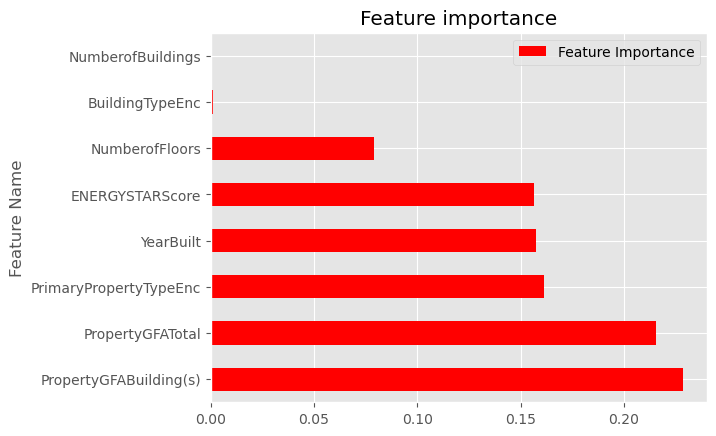

In [149]:
display_feat_imp_rforest(rf11_random, X_train7)

Meilleurs résultats avec random search

#### Sans la variable ENERGYSTARScore

In [152]:
X8 = X7.drop('ENERGYSTARScore', axis = 1)
y8 = y7

In [153]:
X_train8 = X_train7.drop('ENERGYSTARScore', axis = 1)
X_test8 = X_test7.drop('ENERGYSTARScore', axis = 1)

##### Random forest en utilisant le grid search

In [154]:
rf11_bis = rf

In [155]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(rf11_bis, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train8, y_train7)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True)

In [156]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}

In [157]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf11_bis = RandomForestRegressor(**best_params)
rf11_bis.fit(X_train8, y_train7)

y_pred11_bis = rf11_bis.predict(X_test8)

In [158]:
score(y_test7, y_pred11_bis)

MSE : 5935368808447.453 || RMSE : 2436261.236 || MAE : 1652060.403 || r² : 0.484


#### Approche bayésienne

In [159]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective10(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    
    rmse = -cross_val_score(randomF, X8, y8, scoring='neg_root_mean_squared_error', cv=5).mean()

    return rmse

In [160]:
# Lancer l'optimisation bayésienne 
result4 = gp_minimize(objective10, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [161]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result4.x[0]
best_max_depth = result4.x[1]
best_min_samples_split = result4.x[2]
best_min_samples_leaf = result4.x[3]
best_rmse = -result4.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 500
Best max_depth: 18
Best min_samples_split: 20
Best min_samples_leaf: 1
Best RMSE: -2512137.6676023323


In [163]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf11_by2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)

rf11_by2.fit(X_train8, y_train7)

y_pred11_by = rf11_by2.predict(X_test8)

In [164]:
score(y_test7, y_pred11_by)

MSE : 6121957565331.995 || RMSE : 2474258.993 || MAE : 1653341.176 || r² : 0.468


#### Random Search

In [165]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [166]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [167]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train8, y_train7)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [168]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40}

In [169]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf11_random = RandomForestRegressor(**best_params)
rf11_random.fit(X_train8, y_train7)
y_pred11_random = rf11_random.predict(X_test8)

In [170]:
score(y_test7, y_pred11_random)

MSE : 6220806709813.99 || RMSE : 2494154.508 || MAE : 1689188.468 || r² : 0.459


   Feature Importance            Feature Name
4                0.28        PropertyGFATotal
3                0.25  PropertyGFABuilding(s)
6                0.21  PrimaryPropertyTypeEnc
0                0.18               YearBuilt
2                0.08          NumberofFloors
5                0.00         BuildingTypeEnc
1                0.00       NumberofBuildings


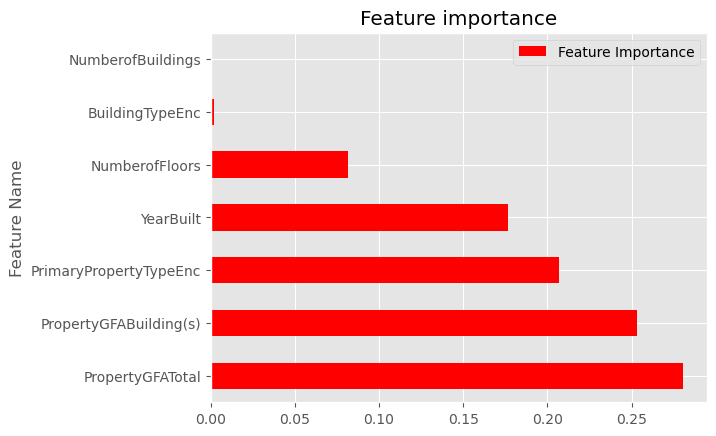

In [171]:
display_feat_imp_rforest(rf11_bis, X_train8)

On remarque que la variable **ENERGYSTARScore** permet d'**améliorer legerement les performances de notre modèle** car sa présence permet d'améliorer les performances si on compare à un modele qui ne contient pas cette variable : les métriques choisies sont meilleures. On remarque que la variable a une importance dans le modèle.  
On parle du cas de l'étude de la **consommation d'energie**.